In [1]:
import qiskit
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from signal_torch.dataset.mfpt import MFPT 
from signal_torch.transforms import transforms

In [2]:
transforms_compose = transforms.Compose([
                        #transforms.AddGaussian(),
                        transforms.ExtractFeatures(list_features=["mean","std","skew","max_min","kurtosis","root_mean_square"]),
                        transforms.ToNumpy()])

In [3]:
MFPT_dataset = MFPT("MFPT", new_length= 512, overlap= 0.0, transform= transforms_compose, download=False)

In [4]:
mfpt_data, mfpt_target = MFPT_dataset._get_numpy()

In [5]:
X_train, _, y_train, _ = train_test_split(mfpt_data, mfpt_target, test_size=0.90, random_state=42)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

Text(0.5, 1.0, 'MFPT Dataset')

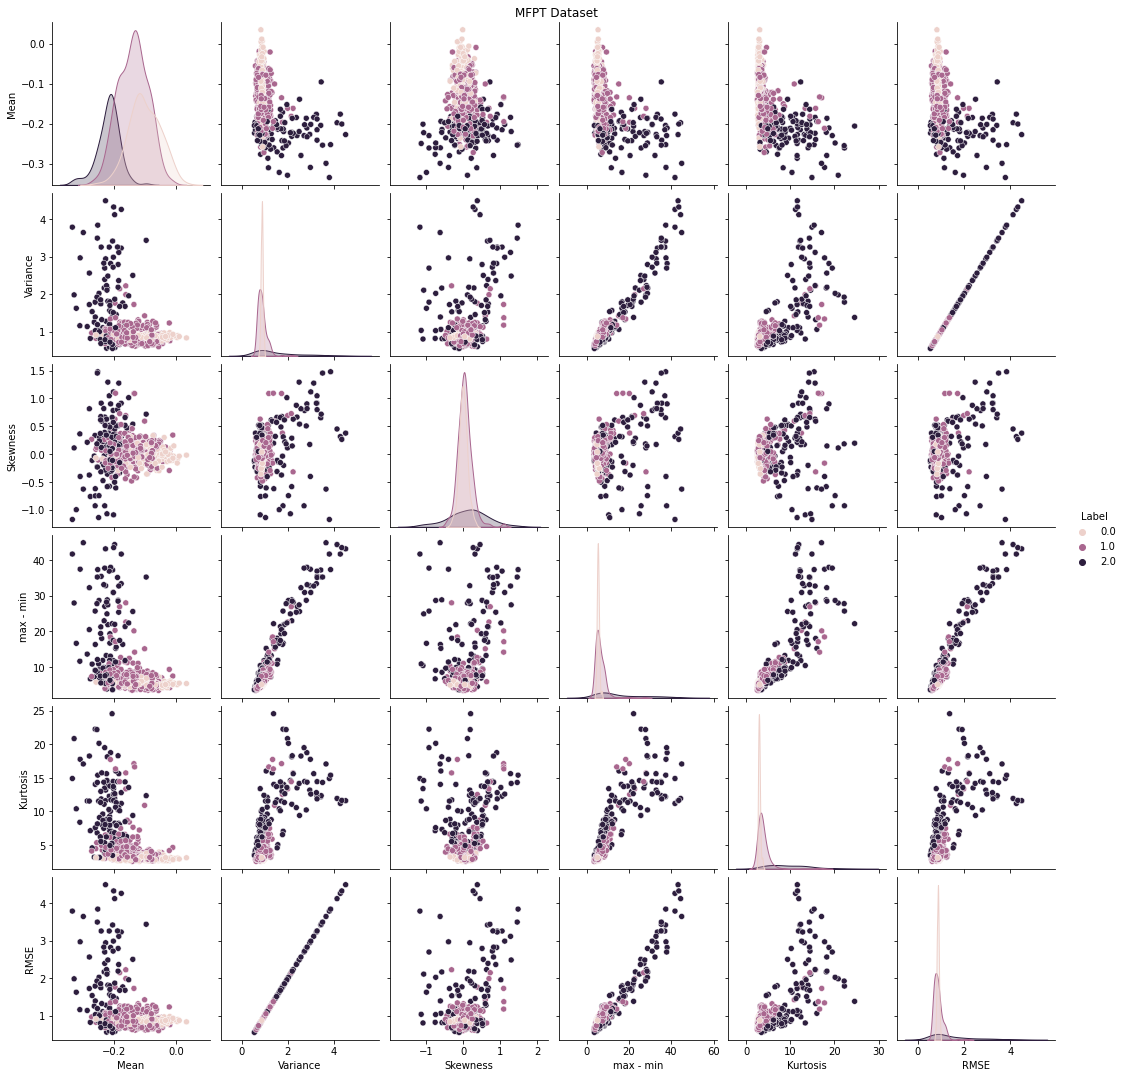

In [16]:
data_df = pd.DataFrame(np.hstack( ( X_train ,y_train.reshape(-1,1)) ), columns = ["Mean","Variance","Skewness","max - min","Kurtosis","RMSE","Label"])
p = sns.pairplot(data_df, hue = "Label")
p.fig.suptitle("MFPT Dataset", y=1.0)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, ADAM

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

algorithm_globals.random_seed = 42

In [10]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=512)
num_inputs = 6

In [11]:
# Define feature map and ansatz
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=3)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw()

┌──────────────────────────────────────────────┐»
q_0: ┤0                                             ├»
     │                                              │»
q_1: ┤1                                             ├»
     │                                              │»
q_2: ┤2                                             ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5]) │»
q_3: ┤3                                             ├»
     │                                              │»
q_4: ┤4                                             ├»
     │                                              │»
q_5: ┤5                                             ├»
     └──────────────────────────────────────────────┘»
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                       ├
«     │                                                                                                                                                        │
«q_1: ┤1                                                                                                                                                       ├
«     │                                                                                                                                                        │
«q_2: ┤2                                                                                                                                                       ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23]) │
«q_3: ┤3                                                                                                                                                       ├
«     │                                                                                                                                                        │
«q_4: ┤4                                                                                                                                                       ├
«     │                                                                                                                                                        │
«q_5: ┤5                                                                                                                                                       ├
«     └────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [12]:
output_shape = 3  

In [13]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % output_shape

# construct QNN
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    output_shape=output_shape,
    interpret=parity,
    quantum_instance=quantum_instance,
)

In [14]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [45]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn, optimizer=COBYLA(), callback=callback_graph
)

In [56]:
objective_func_vals = []
circuit_classifier.fit(X_train, y_train)

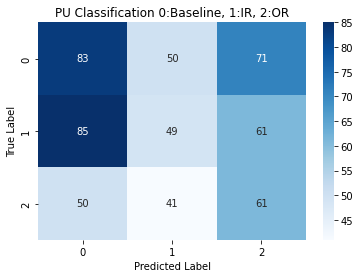

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = circuit_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('PU Classification 0:Baseline, 1:IR, 2:OR');
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');

In [16]:
num_samples_hot = 20
y_one_hot = np.zeros((num_samples_hot, 3))
for i in range(num_samples_hot):
    y_one_hot[i, int(y_train[i])] = 1
X_train_one = X_train[:num_samples_hot]

In [17]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn, optimizer=COBYLA(), callback=callback_graph, one_hot= True, loss= 'cross_entropy'
)

In [18]:
objective_func_vals = []
circuit_classifier.fit(X_train_one, y_one_hot)

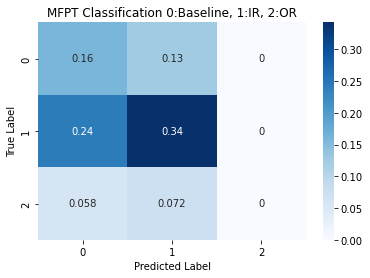

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = circuit_classifier.predict(X_test)
cm = confusion_matrix(y_test, np.argmax(y_pred,axis=1), normalize ="all")

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('MFPT Classification 0:Baseline, 1:OR, 2:IR');
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');

In [41]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, np.argmax(y_pred,axis=1), average='macro')

(0.3689188125049217, 0.37333770387587656, 0.3625663934174572, None)